# Credit Card Fraud Detection


This dataset contains 284,807 European credit card transactions from September 2013, including 492 frauds (~0.172%), making it highly imbalanced. Features V1–V28 are PCA components; Time and Amount are original. The target Class indicates fraud (1) or legitimate (0).
Goal: Build and evaluate models to detect fraudulent transactions, using metrics suitable for imbalanced data, such as the Area Under the Precision–Recall Curve (AUPRC).

## preprocessing

In [2]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
data = pd.read_csv(path + "/creditcard.csv")
data.head()
data.shape
data.info()
data.describe()
data['Class'].value_counts()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Class
0    284315
1       492
Name: count, dtype: int64

As we can see, there are 28 variables obtained from PCA (float), 1 variable indicating time (float), 1 variable indicating the transaction amount, and our target variable Class, which indicates whether a transaction is fraudulent or not (284,807 records)
- there are no categorical data so encoding is not required,
- all columns have non-null values,
- the class distribution shows a strong imbalance towards class 0, i.e., the non-fraudulent transactions

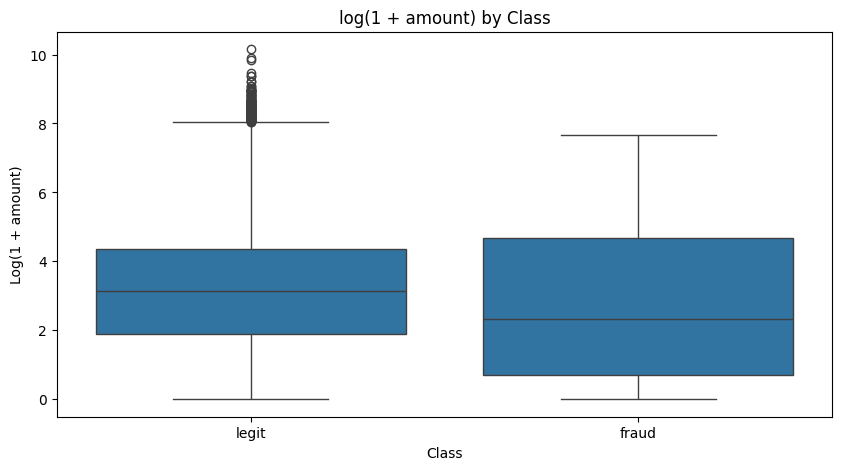

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,5))
sns.boxplot(x='Class', y=np.log1p(data['Amount']), data=data)
plt.xticks([0,1], ['legit', 'fraud'])
plt.title("log(1 + amount) by Class")
plt.ylabel("Log(1 + amount)")
plt.show()

Since the Amount variable contains extremely high outlier values, I opted for a logarithmic transformation of the variable solely for the purpose of plotting Amount in relation to the target variable. As we can see, the legit class has lower variance compared to the fraud class, due to the number of data points available. Nevertheless, there does not appear to be a substantial difference between the two distributions.

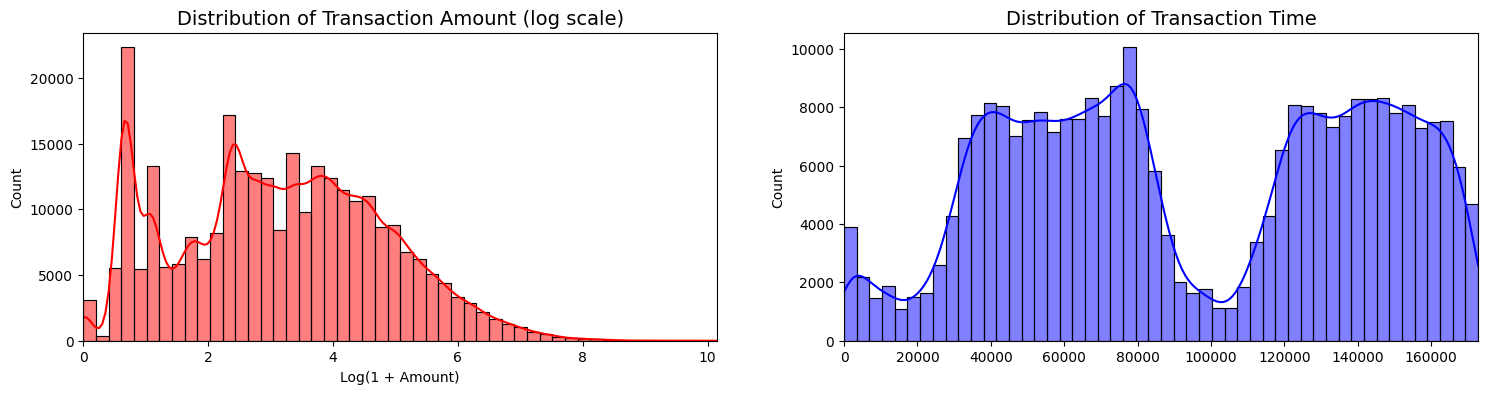

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['Amount'].values
time_val = data['Time'].values

# log transformation for Amount
amount_log = np.log1p(amount_val)

sns.histplot(amount_log, bins=50, kde=True, color='r', ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount (log scale)', fontsize=14)
ax[0].set_xlabel('Log(1 + Amount)')
ax[0].set_xlim([min(amount_log), max(amount_log)])  # usare min/max trasformati

# Distribuzione Time
sns.histplot(time_val, bins=50, kde=True, color='b', ax=ax[1])
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

From the first plot, we can observe that the distribution of transaction amounts is highly variable and does not follow a known distribution. Additionally, for low Amount values, there appears to be considerable fluctuation. From the time distribution, we can see that most transactions are grouped into two, possibly symmetric, distributions. This makes sense, as it is plausible that the majority of transactions occur within specific time intervals.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% per il test
    random_state=42,    # riproducibility
    stratify=y          # keep class distribution
)
X_train_not_scaled=X_train.copy()
X_test_not_scaled=X_test.copy()

scaler = RobustScaler()
X_train[['Time','Amount']] = scaler.fit_transform(X_train[['Time','Amount']])
X_test[['Time','Amount']] = scaler.transform(X_test[['Time','Amount']])

Here, I decided to create a copy of the training set for a future SMOTE analysis. Additionally, the Time and Amount variables are scaled using a robust transformation due to the presence of extremely high outliers.

Note: 
- I decided to keep the outliers because they are meaningful and do not represent erroneous values.
- The correlation analysis between variables in this context does not make sense because the dataset results from a PCA transformation, and consequently, the features live in orthonormal spaces by construction.

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  #for imbalanced datasets
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_new = (rf_model.predict_proba(X_test)[:,1] >= 0.3).astype(int) # threshold at 0.3

y_proba = rf_model.predict_proba(X_test)[:, 1]  # probability for the positive class


Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9605    0.7449    0.8391        98

    accuracy                         0.9995     56962
   macro avg     0.9800    0.8724    0.9194     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC-AUC: 0.9529
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9222    0.8469    0.8830        98

    accuracy                         0.9996     56962
   macro avg     0.9610    0.9234    0.9414     56962
weighted avg     0.9996    0.9996    0.9996     56962

ROC-AUC: 0.9529


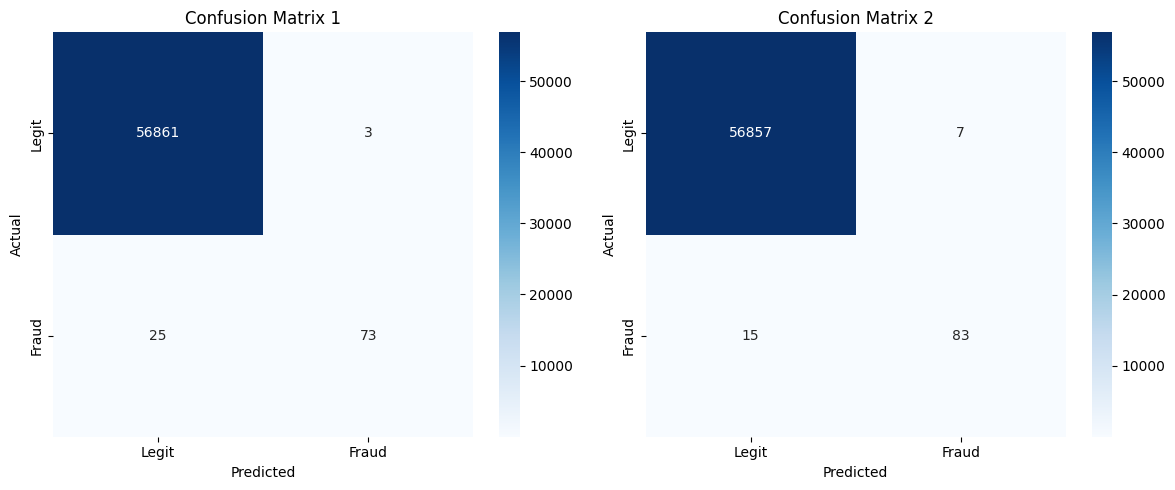

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_new, digits=4))
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred_new)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit','Fraud'], yticklabels=['Legit','Fraud'],
            ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Confusion Matrix 1")

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit','Fraud'], yticklabels=['Legit','Fraud'],
            ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("Confusion Matrix 2")

plt.tight_layout()
plt.show()

The Random Forest model performs well overall and provides a solid baseline for this task. Using class_weight='balanced' helps mitigate the strong class imbalance, but with the standard 0.5 threshold the model still misses several fraud cases.
Lowering the threshold improves recall for the minority class, although this naturally increases false positives. The model is stable and handles the data well, but it remains somewhat cautious in detecting fraud unless the threshold is adjusted.
In summary, Random Forest is a good starting point, but it does not fully exploit the complexity of the data.

# XGboost

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:34:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report XGBoost:
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8542    0.8367    0.8454        98

    accuracy                         0.9995     56962
   macro avg     0.9269    0.9182    0.9225     56962
weighted avg     0.9995    0.9995    0.9995     56962

ROC-AUC: 0.9744
PR-AUC: 0.8786


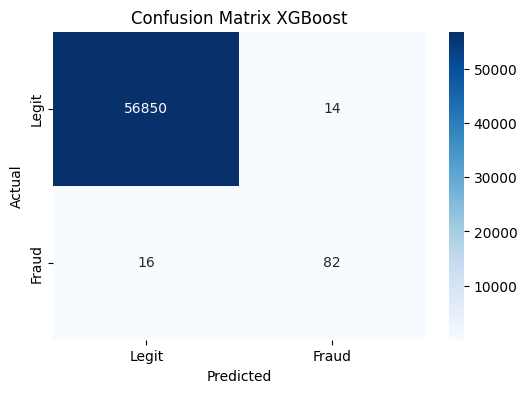

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',  # optimize precision-recall
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int) # Threshold at 0.5

# Report
print("Classification Report XGBoost:")
print(classification_report(y_test, y_pred_xgb, digits=4))

roc_auc = roc_auc_score(y_test, y_proba_xgb)
print(f"ROC-AUC: {roc_auc:.4f}")

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit','Fraud'],
            yticklabels=['Legit','Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix XGBoost")
plt.show()


XGBoost achieves better results than Random Forest, especially in terms of PR-AUC, which is more relevant for imbalanced problems.
The use of scale_pos_weight and an objective based on the precision–recall curve helps the model focus more on the minority class. Even with the default threshold, XGBoost detects more fraud cases while keeping false positives low.
Overall, it separates the two classes more clearly and provides better calibrated probabilities.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:35:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best threshold based on F1: 0.958
Classification Report (XGBoost + optimized threshold):
              precision    recall  f1-score   support

           0     0.9997    0.9999    0.9998     56864
           1     0.9535    0.8367    0.8913        98

    accuracy                         0.9996     56962
   macro avg     0.9766    0.9183    0.9456     56962
weighted avg     0.9996    0.9996    0.9996     56962

ROC-AUC: 0.9830
PR-AUC: 0.8752


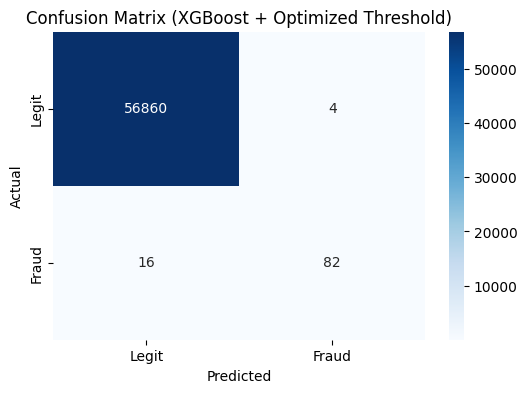

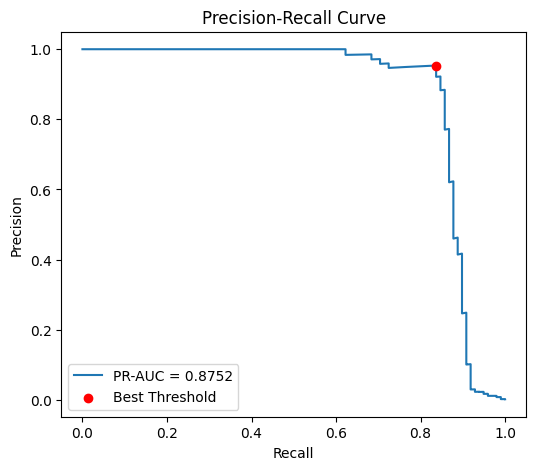

In [ ]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_not_scaled, y_train)

# Scaling di Time e Amount
scaler = RobustScaler()
X_train_res[['Time','Amount']] = scaler.fit_transform(X_train_res[['Time','Amount']])
X_test_scaled = X_test_not_scaled.copy()
X_test_scaled[['Time','Amount']] = scaler.transform(X_test_scaled[['Time','Amount']])

# %% [markdown]
# ## 2. XGBoost con gestione imbalance

# %%
# Calcolo scale_pos_weight per bilanciare dataset
scale_pos_weight = y_train_res.value_counts()[0] / y_train_res.value_counts()[1]

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    eval_metric='aucpr',  # ottimizza Precision-Recall AUC
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train_res, y_train_res)

# %% [markdown]
# ## 3. Predizioni e probabilità

# %%
y_proba = xgb_model.predict_proba(X_test_scaled)[:,1]

# %% [markdown]
# ## 4. Ottimizzazione soglia usando Precision-Recall Curve

# %%
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold based on F1: {best_threshold:.3f}")

y_pred_best = (y_proba >= best_threshold).astype(int)

# %% [markdown]
# ## 5. Valutazione modello

# %%
# Classification report
print("Classification Report (XGBoost + optimized threshold):")
print(classification_report(y_test, y_pred_best, digits=4))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# PR-AUC
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit','Fraud'], 
            yticklabels=['Legit','Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost + Optimized Threshold)")
plt.show()

# %% [markdown]
# ## 6. Optional: curva Precision-Recall

# %%
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label='Best Threshold', zorder=10)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


Applying SMOTE gives the model more balanced data to learn from, and this has a clear positive impact. After resampling, tuning the decision threshold based on the F1-score leads to a better compromise between precision and recall.
The ROC-AUC and PR-AUC both improve, and the model becomes more effective at identifying fraud without generating too many false alarms.
This setup (SMOTE + XGBoost + optimized threshold) performs the best among the tested approaches.